In [1]:
import numpy as np

data = np.load("/home/jkambulo/projects/def-rgmelko/jkambulo/Quantum-Computer-Temperature/data/KZ_Data/12x12/KZ_data_12x12_15_MHz_per_us.npz")
data['rydberg_data'][:,:,-1].shape
# print(data['sweep_rate'])

(12, 12, 1000)

In [3]:
import torch
import numpy as np

def compute_energy(samples: torch.Tensor, logp: torch.Tensor, params: dict, atoms: int = 16):
    """Computes the exact energy based on all the probabilities of each state.

    Args:
        total_configs (torch.Tensor): tensor of all possible states of atoms. Should have shape (2**atoms, atoms)
        logp (torch.Tensor): natural log of the probability of a state, shape (2**atoms,)
        params (dict): Dictionary containing Hamiltonian tuning parameters {'omega', 'delta_per_omega', 'rb_per_a'}
        atoms (int, optional): Number of atoms in grid, assumed to be a perfect square. Defaults to 16.

    Returns:
        float: Calculated energy expectation value
    """
    required_params = {'omega', 'delta_per_omega', 'rb_per_a'}
    assert len(set(params.keys()) ^ required_params) == 0, set(params.keys()) ^ required_params

    C = 862690 * 2 * np.pi
    omega = params['omega']
    rb = (C / omega) ** (1 / 6)
    a = rb / params['rb_per_a']
    delta = params['delta_per_omega'] * omega
    # print(f'c={C} omega={omega} rb={rb} a={a} delta={delta}')

    def compute_interaction(x: torch.Tensor):
        """Computes sum_ij Vij*ni*nj

        Args:
            x (torch.Tensor): tensor of shape (batchsize, natoms)

        Returns:
            torch.tensor: tensor of shape (batchsize,)
        """
        x = x.T
        c = torch.arange(atoms)
        rows = round(np.sqrt(atoms))
        d_inv_6 = torch.triu((1/((c[None]%rows - c[:,None]%rows)**2 +
                                (torch.div(c[None],rows, rounding_mode='floor') - torch.div(c[:,None],rows, rounding_mode='floor'))**2)**3),
                            diagonal=1)
        i, j = torch.triu_indices(atoms, atoms, offset=1)
        filter = (x[i] == 1) & (x[j] == 1)
        return torch.sum(d_inv_6[i[:, None] * filter, j[:, None] * filter], axis=0)

    def compute_rabi(logp):
        L = 2**atoms
        x = torch.arange(L)[:, None]
        i = x ^ (2 ** torch.arange(atoms)[None])  # (2**16, 16)
        return torch.sum(torch.exp(0.5 * (logp[i] + logp[:, None])))

    detuning = -delta * torch.sum(samples, axis=1)
    interaction = C * compute_interaction(samples) / a**6
    rabi_energy = - abs(omega) / 2 * compute_rabi(logp) # - omega to make wavefunction real
    energy = torch.sum(torch.exp(logp) * (detuning + interaction)) + rabi_energy

    return energy.item()

compute_energy(torch.randint(0,2,(16*16,)),np.log(np.ones((16*16,))/256), {'omega':1, 'delta_per_omega':1, 'rb_per_a':1},256)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [1]:
from time import perf_counter
from contextlib import contextmanager


@contextmanager
def catchtime(text) -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start
    print(f'Time: {text} : {perf_counter() - start:.3f} seconds')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchscale.architecture.config import RetNetConfig
from torchscale.architecture.retnet import RetNetDecoder

# vocab size is before embedding. decoder_embed_dim is the number of dimensions in your embedding, ideally less than
# config = RetNetConfig(vocab_size=2, decoder_embed_dim=20, decoder_ffn_embed_dim=1024, decoder_layers=3, decoder_retention_heads=5)
# embedding = nn.Embedding(2, 20)
# linear = nn.Linear(20,2)
# retnet = RetNetDecoder(config, embed_tokens=embedding)
# sum(param.numel() for param in retnet.parameters())
from model_testing.models import RetNet, RNN_1D
retnet = RetNet(12,12, decoder_ffn_embed_dim=500, decoder_layers=3)
params = sum(p.numel() for p in retnet.parameters())
print(params)
for i in range(50,400):
    lstm = RNN_1D(hidden_size=i, model_type='lstm')
    p0 = sum(p.numel() for p in lstm.parameters())
    if p0 > params:
        break
print(i, p0)
for i in range(50,400):
    gru = RNN_1D(hidden_size=i, model_type='gru')
    p0 = sum(p.numel() for p in gru.parameters())
    if p0 > params:
        break
print(i, p0)
for i in range(50,400):
    rnn = RNN_1D(hidden_size=i, model_type='rnn')
    p0 = sum(p.numel() for p in rnn.parameters())
    if p0 > params:
        break
print(i, p0)

44460
104 45138
120 44882
208 44514


In [15]:
x = torch.randint(0,2,(30,256))
incremental_state = {}
for i in range(256):
    output, _ = retnet(x[:, i:i+1], incremental_state=incremental_state)
    print(output.shape)
    raise Exception()
    # output = retnet.linear(output)
    # output = retnet.log_softmax(x)
    # print(incremental_state)
print(output.shape)
print(output)
print(torch.argmax(output, dim=-1))
print(output)
print(incremental_state)
with catchtime("parallel"):
    output, _ = retnet.forward(torch.randint(0,2,(200,256)))
# print(output)

torch.Size([30, 1, 2])


Exception: 

In [30]:
import h5py
import numpy as np
# with h5py.File('file.h5', 'w') as f:
#     f['occs'] = np.array([1,2,3,4,5])
    
from contextlib import contextmanager

@contextmanager
def fileloader(filename):
    try:
        if filename.endswith('.jld') or filename.endswith(".h5"):
            file = h5py.File(filename, 'r')
        yield file
    finally:
        file.close()  
    

    
with fileloader("file.h5") as f:
    print(f['occs'])

<HDF5 dataset "occs": shape (5,), type "<i8">


In [3]:
import numpy as np

optimizer = torch.optim.Adam(retnet.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
data = np.load("/home/jkambulo/projects/def-rgmelko/jkambulo/Quantum-Computer-Temperature/data/KZ_Data/12x12/KZ_data_12x12_15_MHz_per_us.npz")['rydberg_data']
data = torch.from_numpy(data[:,:,1].reshape(12*12, -1)).type(torch.int64)

# input = torch.tensor([[0,1,1,0,0,0],
#                       [0,0,0,1,1,0],
#                       [0,0,1,1,0,0],
#                       [0,0,0,0,1,1],
#                       [1,1,0,0,0,0]])
# target = torch.tensor([[0,0,0,1,0,0],
#                        [0,0,0,0,0,1],
#                        [0,0,0,0,1,0],
#                        [0,0,0,0,0,0],
#                        [0,0,1,0,0,0]])
# print(embedding(target).shape)
# loss_fun = torch.nn.NLLLoss()
batchsize = 100
for epoch in range(1,30):
    for i in range(data.shape[-1]//batchsize):
        input = data[:,i*batchsize:(i+1)*batchsize].T
        order = torch.randperm(5)
        optimizer.zero_grad()
        output = retnet(input)
        # print(output)
        # raise Exception('hey')
        # loss = loss_fun(output[order].view(-1, 2), target[order].view(-1))
        loss = - torch.mean(F.one_hot(input, num_classes=2)*output)
        loss.backward()
        optimizer.step()
        print(loss.item())
        del output

0.566020131111145
0.13552944362163544
0.13326728343963623
0.12589557468891144
0.12600383162498474
0.12744538486003876
0.12763060629367828
0.12687455117702484
0.12541240453720093
0.12825848162174225


KeyboardInterrupt: 

In [19]:
retnet(torch.tensor([[0,1,0,0,0,0,0,0,0,0,0]])).exp()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11x2 and 12x2)

In [6]:
with catchtime('time'):
    retnet.sample(500)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jkambulo/projects/def-rgmelko/jkambulo/py10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
  File "/tmp/ipykernel_45752/1939139578.py", line 2, in <module>
  File "/project/6000317/jkambulo/Quantum-Computer-Temperature/code/sweeping-energy/model_testing/models.py", line 85, in sample
  File "/project/6000317/jkambulo/Quantum-Computer-Temperature/code/sweeping-energy/torchscale/torchscale/architecture/retnet.py", line 378, in forward
  File "/home/jkambulo/projects/def-rgmelko/jkambulo/py10/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
  File "/project/6000317/jkambulo/Quantum-Computer-Temperature/code/sweeping-energy/torchscale/torchscale/architecture/retnet.py", line 184, in forward
  File "/home/jkambulo/projects/def-rgmelko/jkambulo/py10/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
  File "/project/6000317/jkambulo/Quantu

In [61]:
import os
# from model_testing.models import RetNet, RNN_1D
# retnet = RetNet(12,12)
# print(sum(p.numel() for p in retnet.parameters()))
# rnn = RNN_1D(hidden_size=165)
# print(sum(p.numel() for p in rnn.parameters()))


# path = '/home/jkambulo/projects/def-rgmelko/jkambulo/data/KZ_Data/12x12'
# for filename in os.listdir(path):
#     print(filename)
#     with np.load(os.path.join(path, filename)) as file:
#         delta_per_omega_array = file['params']
#         index = (np.abs(delta_per_omega_array - 1.2)).argmin()
#         delta_per_omega = delta_per_omega_array[index]
#         omega = file['rabi_freq']
        
#     dataloader = DataLoader(os.path.join(path, filename), index=index)
#     Lx = 12
#     Ly = Lx
#     h = Hamiltonian(omega=omega, rb_per_a=1.15, delta_per_omega=delta_per_omega, Lx=Lx, Ly=Ly)
    
#     energy_list = []
#     standard_deviation_list = []
#     loss_list = []
#     for repeat in range(30):
#         model = RetNet(Lx, Ly)
#         energy, standard_deviation, loss = train_data(
#             model, h, dataloader, epochs=10, batchsize=100, energy_iterations=1, energy_samples=100
#         )
#         energy_list.append(energy)
#         standard_deviation_list.append(standard_deviation)
#         loss_list.append(loss)
        
#     np.savez(
#         f'sweepdata_energy/{file.split(".")[0]}_training_data.npz',
#         energy=np.array(energy_list),
#         standard_deviation=np.array(standard_deviation_list),
#         loss_list=np.array(loss_list),
#     )
##########################3
# vmc
path = '/home/jkambulo/projects/def-rgmelko/jkambulo/data/KZ_Data/12x12'
for filename in os.listdir(path):
    print(filename)
    with np.load(os.path.join(path, filename)) as file:
        delta_per_omega_array = file['params']
        index = (np.abs(delta_per_omega_array - 1.2)).argmin()
        delta_per_omega = delta_per_omega_array[index]
        omega = file['rabi_freq']
    Lx = 12
    Ly = Lx
    model = RetNet(Lx, Ly, decoder_ffn_embed_dim=200)
    h = Hamiltonian(omega=1, rb_per_a=1.15, delta_per_omega=1.2, Lx=Lx, Ly=Ly)
    energy, standard_deviation, loss_list = train_vmc(model, h, nsamples=100, iterations=150)
    np.savez(
        f'vmc_training_data.npz', energy=energy, standard_deviation=standard_deviation, loss_list=loss_list
    )
    break
#######################################
# model testing
path = '/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=1.10,β=0.255_data/data.jld'
Lx = 12
Ly = Lx
model = RetNet(Lx, Ly)
h = Hamiltonian(omega=1, rb_per_a=1.1, delta_per_omega=1.2, Lx=Lx, Ly=Ly)
dataloader = DataLoader(os.path.join(path, filename))

model = RetNet(Lx, Ly)
energy, standard_deviation, loss_list = train_data(model, h, dataloader, nsamples=100, iterations=150)
np.savez(
    f'retnet_training_qmc.npz', energy=energy, standard_deviation=standard_deviation, loss_list=loss_list
)

model = RNN_1D(165)
energy, standard_deviation, loss_list = train_data(model, h, dataloader, nsamples=100, iterations=150)
np.savez(
    f'retnet_training_qmc.npz', energy=energy, standard_deviation=standard_deviation, loss_list=loss_list
)

64.0

In [12]:
import torch

atoms = 4

samples = torch.randint(0,2,(2,atoms))
print(samples)

x = torch.eye(atoms, dtype=torch.int32)  # (atoms, atoms)
flipped_samples = (x ^ samples.unsqueeze(-2)).reshape(
    len(samples) * atoms, atoms
)  # (nsamples*atoms, atoms)
print(flipped_samples)
print(flipped_samples[:,0])
flipped_logp = torch.mean(flipped_samples.type(torch.float64), dim=-1).reshape(len(samples), atoms)
sample_logp = torch.mean(samples.type(torch.float64), dim=-1)
print()
print(flipped_logp)
print(sample_logp)
# torch.sum(torch.exp( 0.5 * (  )), axis=1)
torch.mean(flipped_logp - sample_logp.unsqueeze(-1), dim=-1)

tensor([[1, 1, 0, 0],
        [1, 1, 1, 1]])
tensor([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 1],
        [0, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
tensor([0, 1, 1, 1, 0, 1, 1, 1])

tensor([[0.2500, 0.2500, 0.7500, 0.7500],
        [0.7500, 0.7500, 0.7500, 0.7500]], dtype=torch.float64)
tensor([0.5000, 1.0000], dtype=torch.float64)


tensor([ 0.0000, -0.2500], dtype=torch.float64)

# Data Analysis

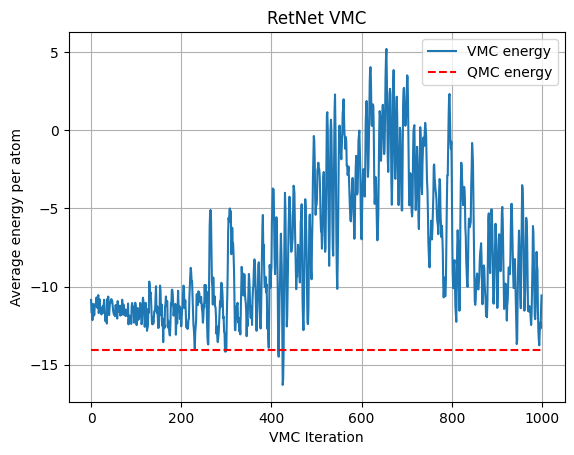

In [23]:
import numpy as np
import matplotlib.pyplot as plt

path = "/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=10.000_data_vmc_retnet.npz"
data = np.load(path)
energy = -224.91588517044647/16
iterations = len(data['energy'])
plt.title("RetNet VMC")
plt.plot(np.arange(iterations), data['energy'], label="VMC energy")
plt.hlines(y=energy, xmin=0, xmax=iterations, linestyle='--', color='r', label="QMC energy")
plt.xlabel("VMC Iteration")
plt.ylabel("Average energy per atom")
plt.legend()
plt.grid()
plt.show()


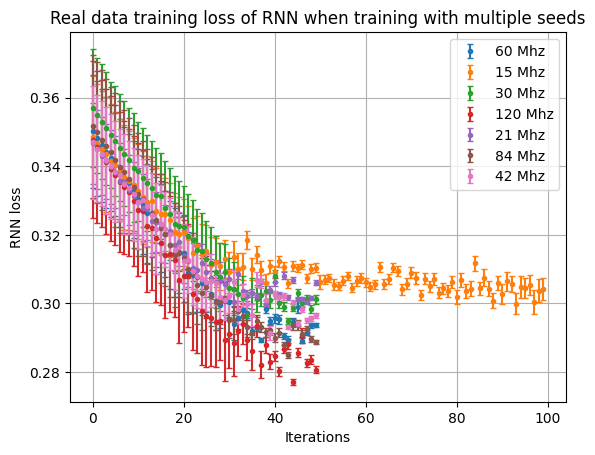

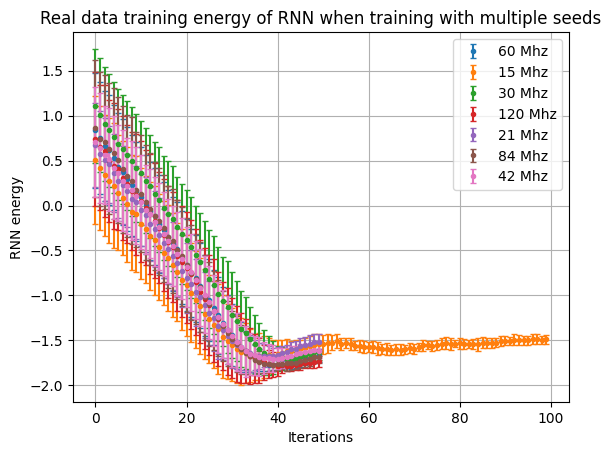

In [34]:
path = "/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy"
for filename in os.listdir(path):
    if not filename.startswith("KZ_data_"):
        continue

    data = np.load(os.path.join(path, filename))

    iterations = data['loss_list'].shape[1]

    plt.errorbar(
        x=np.arange(iterations),
        y=np.mean(data['loss_list'], axis=0),
        yerr=np.std(data['loss_list'], axis=0),
        capsize=2,
        fmt='.',
        label=f"{filename.split('_')[3]} Mhz",
    )
plt.ylabel("RNN loss")
plt.xlabel("Iterations")
plt.title("Real data training loss of RNN when training with multiple seeds")
plt.legend()
plt.grid()
plt.show()

for filename in os.listdir(path):
    if not filename.startswith("KZ_data_"):
        continue

    data = np.load(os.path.join(path, filename))

    iterations = data['energy'].shape[1]

    plt.errorbar(
        x=np.arange(iterations),
        y=np.mean(data['energy'], axis=0),
        yerr=np.std(data['energy'], axis=0),
        capsize=2,
        fmt='.',
        label=f"{filename.split('_')[3]} Mhz",
    )
plt.ylabel("RNN energy")
plt.xlabel("Iterations")
plt.title("Real data training energy of RNN when training with multiple seeds")
plt.legend()
plt.grid()
plt.show()

(7, 30) 7
(5, 30) 5


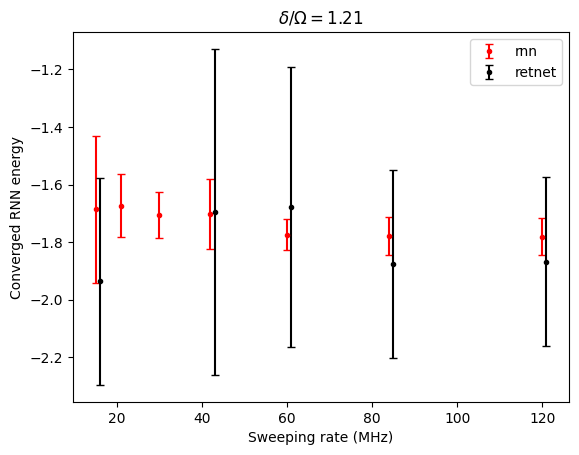

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt

folder = "/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy"

for model,dist, color in zip(['rnn', 'retnet'],[0,1],['r','k']):
    sweeping_rate = []
    energy = []
    all_energy = []
    energy_std = []
    for filename in os.listdir(folder):
        if not (filename.startswith("KZ_data_12x12_") and model in filename):
            continue
        data = np.load(os.path.join(folder, filename))
        i = np.argmin(np.mean(data['energy'], axis=0))
        energy.append(np.mean(data['energy'][:,i]))
        energy_std.append(np.std(data['energy'][:,i]))
        sweeping_rate.append(int(filename.split('_')[3]))
        all_energy.append(data['energy'][:,i])
    print(np.array(all_energy).shape, len(sweeping_rate))
    # plt.plot(sweeping_rate, np.array(all_energy), marker='.', linestyle='none',c=color)
    plt.errorbar(x=np.array(sweeping_rate)+dist, y=energy, yerr=energy_std, capsize=3, fmt='.', color=color, label=model)
    # break
# plt.ylim([-2,-1.3])
plt.xlabel("Sweeping rate (MHz)")
plt.ylabel("Converged RNN energy")
plt.title(r"$\delta/\Omega=1.21$")
plt.legend()
plt.show()

17.68629859184872


(0.3445, 0.35)

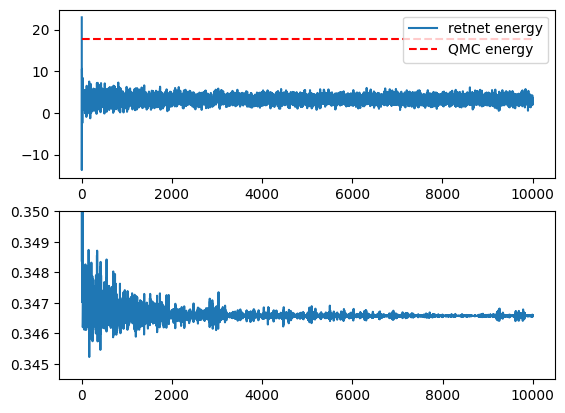

In [43]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=0.000010_data_retnet_qmc_allenergy.npz'
qmc_energy = 282.9807774695795/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
ax[1].set_ylim(0.3445,0.35)

-14.057242823152905


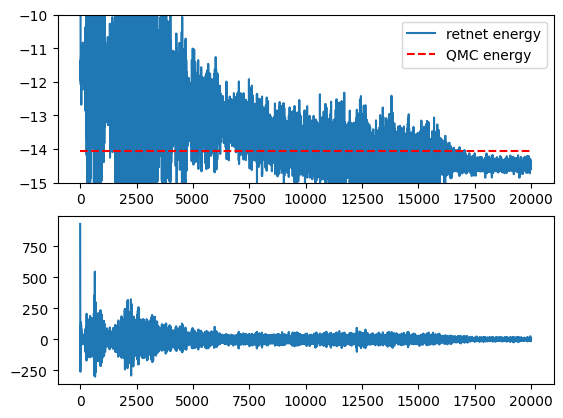

In [58]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=0.000010_data_retnet_vmc.npz'
qmc_energy = -224.91588517044647/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
ax[0].set_ylim([-15,-10])
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-12.780865720653319


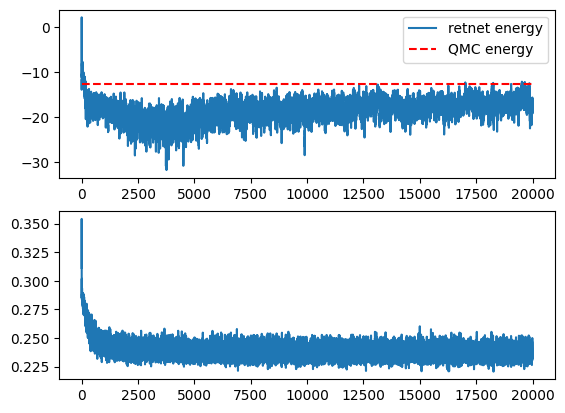

In [74]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=0.100000_data_retnet_vmc_train.npz'
qmc_energy = -204.4938515304531/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
# ax[0].set_ylim([-15,-10])
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-14.057242823152905


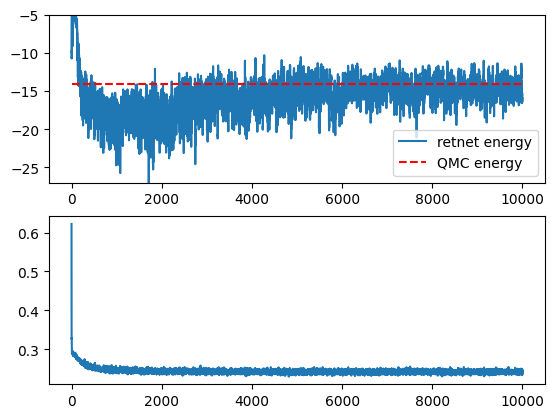

In [67]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=10.000_data_retnet_qmc_allenergy.npz'
qmc_energy = -224.91588517044647/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
ax[0].set_ylim([-27,-5])
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-14.057242823152905


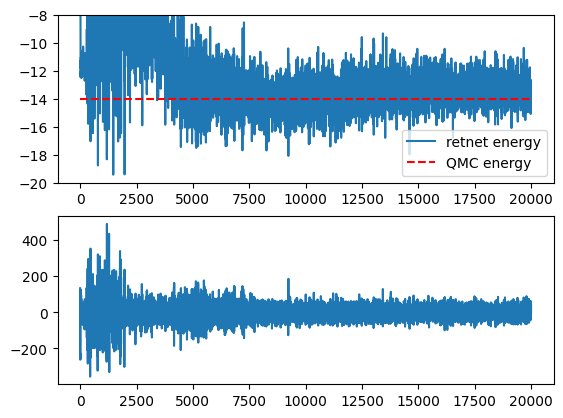

In [70]:
import numpy as np
import matplotlib.pyplot as plt

path = '//home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=10.000_data_retnet_vmc.npz'
qmc_energy = -224.91588517044647/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
ax[0].set_ylim([-20,-8])
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-14.057242823152905


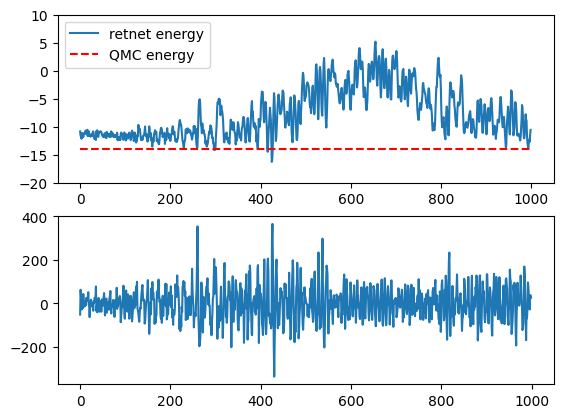

In [73]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/4x4,Rb=1.20,Δ=1.10,β=10.000_data_vmc_retnet.npz'
qmc_energy = -224.91588517044647/16
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
_, ax = plt.subplots(2)
ax[0].plot(energy, label='retnet energy')
ax[0].set_ylim([-20,10])
ax[1].plot(loss)
ax[0].hlines(y=qmc_energy,xmin=0,xmax=len(energy), linestyle='--', color='r', label='QMC energy')
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-12.780865720653319


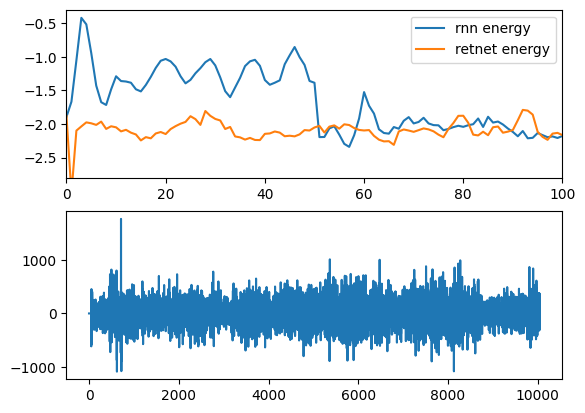

In [86]:
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/KZ_data_16x16_42_MHz_per_us_rnn_train_2_vmc.npz'
path2= '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/KZ_data_16x16_42_MHz_per_us_retnet_sweep_energy.npz'
print(qmc_energy)
with np.load(path) as file:
    energy = file['energy']
    loss = file['loss_list']
    energy_standard_deviation = file['standard_deviation']
    
with np.load(path2) as file:
    energy2 = file['energy']
    loss2 = file['loss_list']
    energy_standard_deviation2 = file['standard_deviation']
_, ax = plt.subplots(2)
ax[0].plot(energy, label='rnn energy')
ax[0].plot(energy2, label='retnet energy')
ax[0].set_ylim([-2.8,-0.3])
ax[0].set_xlim([0,100])
ax[1].plot(loss)
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

-12.780865720653319


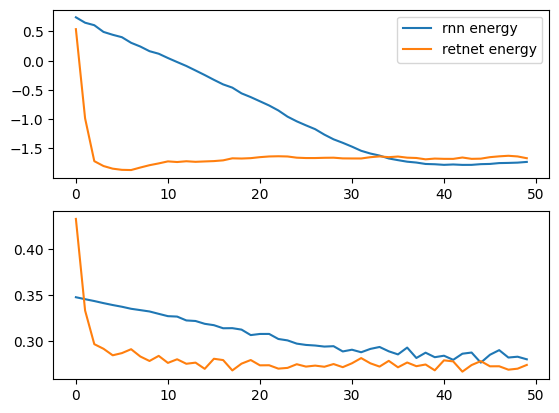

In [91]:
import numpy as np
import matplotlib.pyplot as plt

path2 = '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/KZ_data_12x12_120_MHz_per_us_retnet_sweeprate_energy.npz'
path= '/home/jkambulo/projects/def-rgmelko/jkambulo/code/sweeping-energy/model_testing/sweepdata_energy/KZ_data_12x12_120_MHz_per_us_rnn32_sweeprate_energy.npz'
print(qmc_energy)
with np.load(path) as file:
    energy = np.mean(file['energy'], axis=0)
    loss = np.mean(file['loss_list'], axis=0)
    energy_standard_deviation = file['standard_deviation']
    
with np.load(path2) as file:
    energy2 = np.mean(file['energy'], axis=0)
    loss2 = np.mean(file['loss_list'], axis=0)
    energy_standard_deviation2 = file['standard_deviation']
_, ax = plt.subplots(2)
ax[0].plot(energy, label='rnn energy')
ax[0].plot(energy2, label='retnet energy')
# ax[0].set_ylim([-2.8,-0.3])
# ax[0].set_xlim([0,100])
ax[1].plot(loss)
ax[1].plot(loss2)
ax[0].legend()
# plt.xlim([0,200])
# ax[1].set_ylim(0.3445,0.35)

In [6]:
with np.load("/home/jkambulo/projects/def-rgmelko/jkambulo/data/KZ_Data/12x12/KZ_data_12x12_15_MHz_per_us.npz") as file:
    delta_per_omega_array = file['params']
    index = (np.abs(delta_per_omega_array - 1.2)).argmin()
    delta_per_omega = delta_per_omega_array[index]
    omega = file['rabi_freq']
    print(delta_per_omega)

1.215137614678899
